In [1]:
from lenskit.datasets import ML100K
from transform_data_representation import transform_dense_to_sparse_data
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import os
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV
from collections import Counter

Required directory 'C:\Users\Jorane Rogier\Documents\studie\year2\Research Internship\RecSysProject/output/' exists 
Required directory 'C:\Users\Jorane Rogier\Documents\studie\year2\Research Internship\RecSysProject/output/synthetic_data/' exists 
Required directory 'C:\Users\Jorane Rogier\Documents\studie\year2\Research Internship\RecSysProject/output/partitioned_data/' exists 


In [99]:
test_saving_file = 'test_img.png'

In [42]:
# Load input data
ml100k = ML100K('ml-100k')
ratings = ml100k.ratings
ratings = ratings[['user', 'item', 'rating']]
user_item_matrix = ratings.pivot(*ratings.columns)
user_item_matrix = user_item_matrix.fillna(0)
user_item_matrix.columns = user_item_matrix.columns.astype(str)
df = pd.DataFrame(user_item_matrix)

In [3]:
'''from collections import Counter
# samples = synthetic 
# data = original

n_users = samples.userid.unique().shape[0]
n_items = samples.itemid.unique().shape[0]
n_usersd = data.userid.unique().shape[0]
n_itemsd = data.itemid.unique().shape[0] 
# n_userrd = random.userid.unique().shape[0]
# n_itemsrd = random.itemid.unique().shape[0]

# Sort movie ratings in decreasing order of ratings
data_movieratings = Counter(data['userid'])
ctr_movieratings = Counter(samples['userid'])
# ran_movieratings = Counter(random['userid'])

#plt.xticks(rankings['movieId'])
plt.figure(figsize=(6,5))
plt.grid(linewidth=0.4, color='lightgray') 
plt.bar(np.arange(n_users),sorted(ctr_movieratings.values(),reverse = True), edgecolor='orchid', color='None')# color= "orchid")
# plt.bar(np.arange(n_userrd),sorted(ran_movieratings.values(),reverse = True), edgecolor='deepskyblue', color='None')# color= "deepskyblue")
plt.bar(np.arange(n_usersd),sorted(data_movieratings.values(),reverse = True), edgecolor='bisque', color='None')# color= "bisque")
plt.title('Distribution of ratings among users', size= 20, fontweight='bold')
plt.xlabel('Users', size= 20)#, fontweight='bold')
plt.ylabel('Number of ratings', size= 20)#, fontweight='bold')
plt.grid('on')
plt.legend(["Ctgan", "Empirical", "Original"], prop={'size': 18})
plt.savefig ("ml100k_UIM_userDistribution.pdf")
plt.show()'''

'from collections import Counter\n# samples = synthetic \n# data = original\n\nn_users = samples.userid.unique().shape[0]\nn_items = samples.itemid.unique().shape[0]\nn_usersd = data.userid.unique().shape[0]\nn_itemsd = data.itemid.unique().shape[0] \n# n_userrd = random.userid.unique().shape[0]\n# n_itemsrd = random.itemid.unique().shape[0]\n\n# Sort movie ratings in decreasing order of ratings\ndata_movieratings = Counter(data[\'userid\'])\nctr_movieratings = Counter(samples[\'userid\'])\n# ran_movieratings = Counter(random[\'userid\'])\n\n#plt.xticks(rankings[\'movieId\'])\nplt.figure(figsize=(6,5))\nplt.grid(linewidth=0.4, color=\'lightgray\') \nplt.bar(np.arange(n_users),sorted(ctr_movieratings.values(),reverse = True), edgecolor=\'orchid\', color=\'None\')# color= "orchid")\n# plt.bar(np.arange(n_userrd),sorted(ran_movieratings.values(),reverse = True), edgecolor=\'deepskyblue\', color=\'None\')# color= "deepskyblue")\nplt.bar(np.arange(n_usersd),sorted(data_movieratings.values()

In [4]:
def compute_taus(df, minimum=0, maximum=1000000, rounding_tau=2):
    """
    Function to compute global ranking and user ranking, followed by kendall's tau
    INPUT: 
    * min, max -> items to be removed below/higher than these values
    * df -> input dataframe
    * rounding_tau -> rounding value for kendall's tau

    OUTPUT:
    * user_mainstreamnesses (tau, p-value)
    * taus 
    """
    # Create Global Item Ranking (GIR), looping over all items, count how often the item is watched
    GIR = {}
    for col in df:
        # does not take into account movies that have not been watched
        summed_rating = df[col].sum()

        # only take into account items that have been # ratings between minimum and maximum
        if ((df[col].astype(bool).sum(axis=0) >= minimum) and (df[col].astype(bool).sum(axis=0) <= maximum)):
            GIR[col] = summed_rating

    ranks_GIR = {k: v for k,v in sorted(GIR.items(), key=lambda item: item[1], reverse=True)}
    ranks_GIR_items = [*ranks_GIR]
    print(f'Length of ranks_GIR_items: {len(ranks_GIR_items)}')
    
    # Compute user mainstreaminess (UM)
    user_mainstreamnesses = {}
    taus = []
    for uid in range(len(df)):
        user_dict = {}
        for item_id in df.columns:
            rating = df.iloc[uid][item_id]# uid here is not the true user_id (which is uid + 1), iloc needs integer, thus starting at 0
            # only take into account items that have been rated > minimum & < maximum times
            if item_id in GIR:
                user_dict[item_id] = rating
        
        # Rank the items for the user based on given ratings
        ranks_user = {k: v for k,v in sorted(user_dict.items(), key=lambda item: item[1], reverse=True)}
        ranks_user_items = [*ranks_user]
        
        # compute the mainstreaminess measure with Kendall's rank-order correlation
        tau, p_value = stats.kendalltau(ranks_GIR_items, ranks_user_items)
        user_mainstreamnesses[uid+1] = [tau, p_value] # Here, the actual user_id is used
        taus.append(round(tau, rounding_tau))
        
    print("Finished computing users' mainstreaminesses")
    
    # Plot taus to investigate the values
    plt.figure(0)
    plt.hist(taus)
    plt.xlabel("Kendall's tau")
    plt.ylabel("Counts")
    
    return user_mainstreamnesses, pd.Series(taus)

In [5]:
def compute_best_bandwidth(d):
    """
    Function to find the best bandwidth for kernel density estimation, given input d.
    """
    bandwidths = 10 ** np.linspace(-1, 1, 100)
    grid = GridSearchCV(KernelDensity(kernel='gaussian'),
                        {'bandwidth': bandwidths})
    grid.fit(d[:, None])
    print(grid.best_params_)
    return grid.best_params_

In [6]:
def plot_distribution(df_orig, df_syn):   
    plt.plot(range(len(df_orig)), df_orig['counts'], label='Original')
    plt.fill_between(range(len(df_orig)), df_orig['counts'], color='#539ecd', alpha=0.5)

    plt.plot(range(len(df_syn)), df_syn['counts'], label='CTGAN')
    plt.fill_between(range(len(df_syn)), df_syn['counts'], color='#4cad6e', alpha=0.5)
    plt.legend(loc='upper right')


In [119]:
def transform_sparse_to_dense_data(sparse_df):
    if 'total' in sparse_df.columns:
        sparse_df = sparse_df.reset_index(drop=True)
        sparse_df = sparse_df.drop(labels='total', axis=1)
        print(sparse_df.columns)
    transformed_data = []
    for uid in range(len(sparse_df)):
        for item_id in sparse_df.columns:
            rating = sparse_df.iloc[uid][item_id]
            #print(f"user {uid} - item: {item_id} - rating: {rating}")
            if rating != 0:
                user_id = int(uid)+1
                sample = [user_id, int(item_id), str(int(rating))]
                transformed_data.append(sample)
            
    df = pd.DataFrame(transformed_data, columns =['user', 'item', 'rating'])
    return df

In [146]:
def get_division_characteristics(user_mainstreamnesses, plot_saving_filename, tau_cutoff=0.02):
    # Get the user-ids which have tau < tau_cutoff (beyond mainstream users, bmu)    
    bmu = [k for k, v in user_mainstreamnesses.items() if float(v[0]) < float(tau_cutoff)] # For some reason does not work?
    #print(user_mainstreamnesses.items())
    print(len(bmu))
    
    # Get the user-ids which have tau >= tau_cutoff (mainstream users, mu)
    mu = [k for k, v in user_mainstreamnesses.items() if float(v[0]) >= tau_cutoff]
    print(len(mu))
    
    # Since the user-id's started at 1, but for indexing we start at 0, 
    # we subtract 1 from all elements in the lists
    bmu[:] = [n-1 for n in bmu]
    mu[:] = [n-1 for n in mu]
    
    df_bmu = df.iloc[bmu]
    df_bmu = df_bmu[df_bmu.columns].astype(int)
    df_mu = df.iloc[mu]
    df_mu = df_mu[df_mu.columns].astype(int)
    # concat both dataframes vertically
    df_all = pd.concat([df_bmu, df_mu], axis=0)
    df_all = df_all[df_all.columns].astype(int)
    
    # Save locally as csv file
    df_bmu.to_csv('orig_sparse_beyond_mainstream_tau_0.07_l20.csv')
    df_all.to_csv('orig_sparse_all_tau_0.07_l20.csv')
    
    # check user distribution
    df_bmu_dense = transform_sparse_to_dense_data(df_bmu)
    df_mu_dense = transform_sparse_to_dense_data(df_mu)

    '''df_bmu_counts = df_bmu_dense.groupby('item').size().reset_index(name='counts')
    df_bmu_counts = df_bmu_counts.sort_values(by='counts', ascending=False)
    df_mu_counts = df_mu_dense.groupby('item').size().reset_index(name='counts')
    df_mu_counts = df_mu_counts.sort_values(by='counts', ascending=False)

    plot_distribution(df_bmu_counts, df_mu_counts)'''
    
    # samples = synthetic 
    # data = original

    n_users_bmu = df_bmu_dense.user.unique().shape[0]
    n_items_bmu = df_bmu_dense.item.unique().shape[0]
    n_usersd_mu = df_mu_dense.user.unique().shape[0]
    n_itemsd_mu = df_mu_dense.item.unique().shape[0] 
    # n_userrd = random.userid.unique().shape[0]
    # n_itemsrd = random.itemid.unique().shape[0]

    # Sort movie ratings in decreasing order of ratings
    data_movieratings = Counter(df_mu_dense['user'])
    ctr_movieratings = Counter(df_bmu_dense['user'])
    # ran_movieratings = Counter(random['userid'])

    #plt.xticks(rankings['movieId'])
    plt.figure(figsize=(6,5))
    plt.grid(linewidth=0.4, color='lightgray') 
    #plt.bar(np.arange(n_users_bmu),sorted(ctr_movieratings.values(),reverse = True), edgecolor='orchid', color='None', alpha=0.4)# color= "orchid")
    # plt.bar(np.arange(n_userrd),sorted(ran_movieratings.values(),reverse = True), edgecolor='deepskyblue', color='None')# color= "deepskyblue")
    plt.plot(np.arange(n_users_bmu),sorted(ctr_movieratings.values(),reverse = True), label='Beyond mainstream', color='blue')# color= "orchid")
    plt.fill_between(range(len(np.arange(n_users_bmu))),sorted(ctr_movieratings.values(),reverse = True), color='#0868ac', alpha=0.5)
    #plt.bar(np.arange(n_usersd_mu),sorted(data_movieratings.values(),reverse = True), edgecolor='bisque', color='None', alpha=0.4)# color= "bisque")
    plt.plot(np.arange(n_usersd_mu),sorted(data_movieratings.values(),reverse = True), label='Mainstream', color='green')# color= "bisque")
    plt.fill_between(range(len(np.arange(n_usersd_mu))), sorted(data_movieratings.values(),reverse = True), color='#bae4bc', alpha=0.5)
    
    plt.title('Distribution of ratings among users', size= 20, fontweight='bold')
    plt.xlabel('Users', size= 20)#, fontweight='bold')
    plt.ylabel('Number of ratings', size= 20)#, fontweight='bold')
    plt.grid('on')
    #plt.legend(["Beyond-mainstream", "Mainstream"], prop={'size': 18})
    plt.legend(loc='upper right')
    plt.savefig (f"{plot_saving_filename}.pdf")
    plt.show()
    
    df_bmu_dense.to_csv(f'orig_dense_beyond_mainstream_tau_0.07_l20.csv')
    df_mu_dense.to_csv(f'orig_dense_mainstream_tau_0.07_l20.csv')
    
    # compute non-zero values per row for both dataframes
    df_bmu['total'] = df.gt(0).sum(axis=1)
    df_mu['total'] = df.gt(0).sum(axis=1)
        
        
    # Compare the characteristics.
    data = {'Characteristic': ['Min. #Ratings', 'Max. #Ratings', 'Mean #Ratings', '# Users'],
                'Beyond-mainstream': [df_bmu['total'].min(), df_bmu['total'].max(), df_bmu['total'].mean(), len(bmu)],
                'Mainstream': [df_mu['total'].min(), df_mu['total'].max(), df_mu['total'].mean(), len(mu)]}

    compare_df = pd.DataFrame(data)
    print(compare_df)
    return compare_df
    

## Look into data characteristics without removing items

### Investigate taus

Length of ranks_GIR_items: 1683
Finished computing users' mainstreaminesses


<ipython-input-5-1d79585076c0>:8: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  grid.fit(d[:, None])


{'bandwidth': 0.1}


<ipython-input-126-cfbe8762e0f3>:8: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  kde.fit(taus_df[:, None])


(-0.001, 40.0)

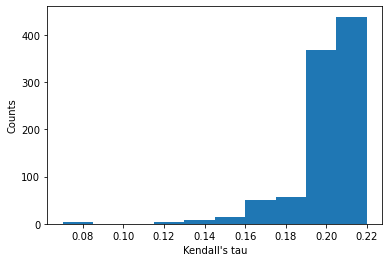

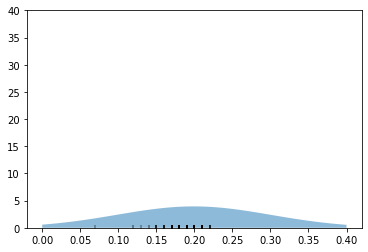

In [126]:
user_mainstreamnesses, taus_df = compute_taus(df)
best_bandwidth = compute_best_bandwidth(taus_df)

# instantiate and fit the KDE model
kde = KernelDensity(bandwidth=best_bandwidth['bandwidth'], kernel='gaussian')
x_d2 = np.linspace(0, 0.4, 1000)

kde.fit(taus_df[:, None])

# score_samples returns the log of the probability density
logprob = kde.score_samples(x_d2[:, None])

plt.figure(1)
plt.fill_between(x_d2, np.exp(logprob), alpha=0.5)
plt.plot(taus_df, np.full_like(taus_df, -0.01), '|k', markeredgewidth=0.2)
plt.ylim(-0.001, 40)

### Divide users into two groups, based on mainstreaminess score, and compare group-size characteristics

381
562


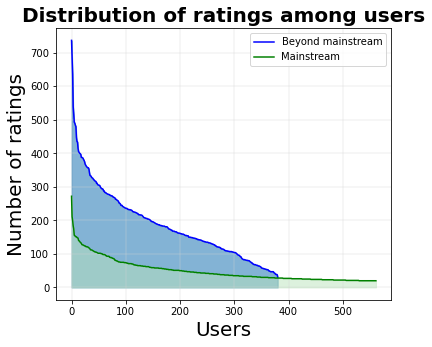

  Characteristic  Beyond-mainstream  Mainstream
0  Min. #Ratings          31.000000   20.000000
1  Max. #Ratings         737.000000  272.000000
2  Mean #Ratings         188.984252   49.816726
3        # Users         381.000000  562.000000


In [98]:
tau_cutoff = 0.2
compare_df = get_division_characteristics(user_mainstreamnesses, 'test.png', tau_cutoff)

18
925


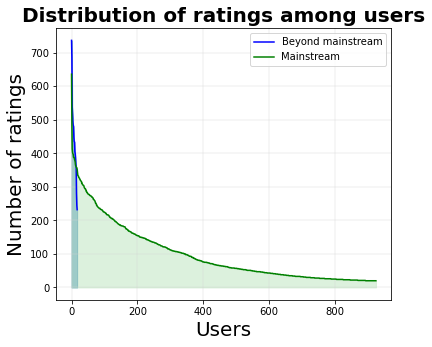

  Characteristic  Beyond-mainstream  Mainstream
0  Min. #Ratings         232.000000   20.000000
1  Max. #Ratings         737.000000  636.000000
2  Mean #Ratings         440.611111   99.534054
3        # Users          18.000000  925.000000


In [11]:
tau_cutoff = 0.15
plot_saving_filename = "plot_user_distribution_tau_015"
compare_df = get_division_characteristics(user_mainstreamnesses, plot_saving_filename, tau_cutoff)

47
896


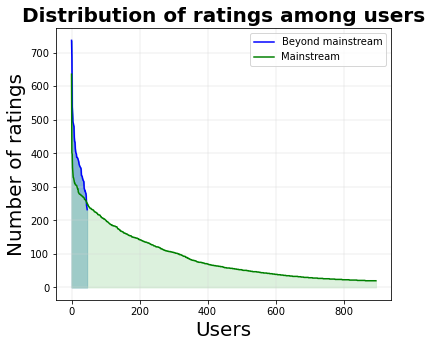

  Characteristic  Beyond-mainstream  Mainstream
0  Min. #Ratings         232.000000   20.000000
1  Max. #Ratings         737.000000  636.000000
2  Mean #Ratings         380.638298   91.640625
3        # Users          47.000000  896.000000


In [12]:
# This is the one
tau_cutoff = 0.165
plot_saving_filename = "plot_user_distribution_tau_0165"
compare_df = get_division_characteristics(user_mainstreamnesses, plot_saving_filename, tau_cutoff)

102
841
Index(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10',
       ...
       '1673', '1674', '1675', '1676', '1677', '1678', '1679', '1680', '1681',
       '1682'],
      dtype='object', name='item', length=1682)
Index(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10',
       ...
       '1673', '1674', '1675', '1676', '1677', '1678', '1679', '1680', '1681',
       '1682'],
      dtype='object', name='item', length=1682)


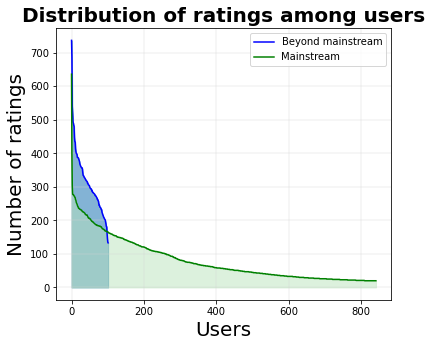

  Characteristic  Beyond-mainstream  Mainstream
0  Min. #Ratings         134.000000   21.000000
1  Max. #Ratings         738.000000  637.000000
2  Mean #Ratings         314.598039   81.871581
3        # Users         102.000000  841.000000


In [128]:
tau_cutoff = 0.18
plot_saving_filename = "plot_user_distribution_tau_018"
compare_df = get_division_characteristics(user_mainstreamnesses, test_saving_file, tau_cutoff)

60
883
Index(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10',
       ...
       '1673', '1674', '1675', '1676', '1677', '1678', '1679', '1680', '1681',
       '1682'],
      dtype='object', name='item', length=1682)
Index(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10',
       ...
       '1673', '1674', '1675', '1676', '1677', '1678', '1679', '1680', '1681',
       '1682'],
      dtype='object', name='item', length=1682)


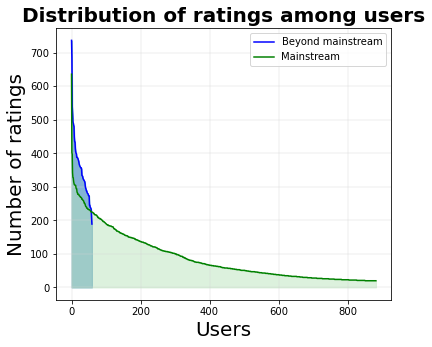

  Characteristic  Beyond-mainstream  Mainstream
0  Min. #Ratings         190.000000   21.000000
1  Max. #Ratings         738.000000  637.000000
2  Mean #Ratings         357.716667   90.011325
3        # Users          60.000000  883.000000


In [129]:
tau_cutoff = 0.17
compare_df = get_division_characteristics(user_mainstreamnesses, test_saving_file, tau_cutoff)

### Investigate item rating count

943


Text(0, 0.5, 'Counts')

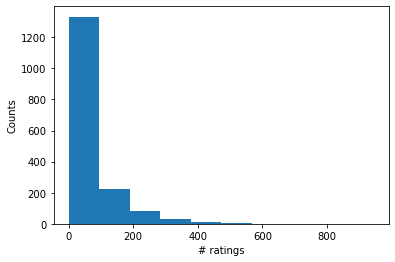

In [130]:
# Count the amount of rating events per item
rating_count_per_item = df.gt(0).sum(axis=0)
print(rating_count_per_item.max())

plt.hist(rating_count_per_item)
plt.xlabel("# ratings")
plt.ylabel("Counts")

Here, we clearly see the longtail distribution of the items.

### Investigate user rating count

Text(0, 0.5, 'Counts')

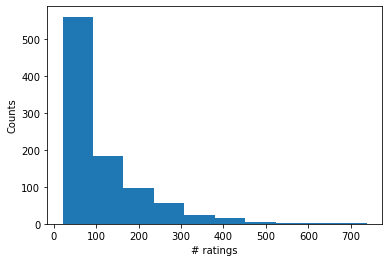

In [131]:
# Count the amount of rating events per user
df['total'] = df.gt(0).sum(axis=1)
rating_count_per_user = df['total']

plt.hist(rating_count_per_user)
plt.xlabel("# ratings")
plt.ylabel("Counts")

Here, we clearly see the longtail distribution of the user ratings. 
We will first remove the items with few ratings (<20)

## Look into data characteristics when removing items < 20 ratings

Length of ranks_GIR_items: 940
Finished computing users' mainstreaminesses


<ipython-input-5-1d79585076c0>:8: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  grid.fit(d[:, None])


{'bandwidth': 0.1}


<ipython-input-144-f8770581ab24>:8: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  kde.fit(taus_df[:, None])


(-0.001, 40.0)

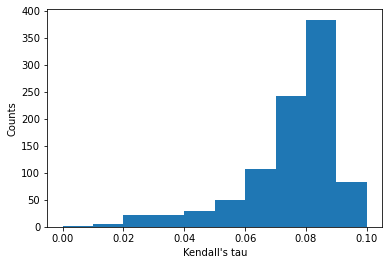

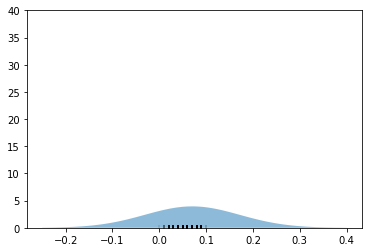

In [144]:
user_mainstreamnesses, taus_df = compute_taus(df, minimum=20)
best_bandwidth = compute_best_bandwidth(taus_df)

# instantiate and fit the KDE model
kde = KernelDensity(bandwidth=best_bandwidth['bandwidth'], kernel='gaussian')
x_d2 = np.linspace(-0.25, 0.4, 1000)

kde.fit(taus_df[:, None])

# score_samples returns the log of the probability density
logprob = kde.score_samples(x_d2[:, None])

plt.figure(1)
plt.fill_between(x_d2, np.exp(logprob), alpha=0.5)
plt.plot(taus_df, np.full_like(taus_df, -0.01), '|k', markeredgewidth=0.2)
plt.ylim(-0.001, 40)

337
606
Index(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10',
       ...
       '1673', '1674', '1675', '1676', '1677', '1678', '1679', '1680', '1681',
       '1682'],
      dtype='object', name='item', length=1682)
Index(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10',
       ...
       '1673', '1674', '1675', '1676', '1677', '1678', '1679', '1680', '1681',
       '1682'],
      dtype='object', name='item', length=1682)


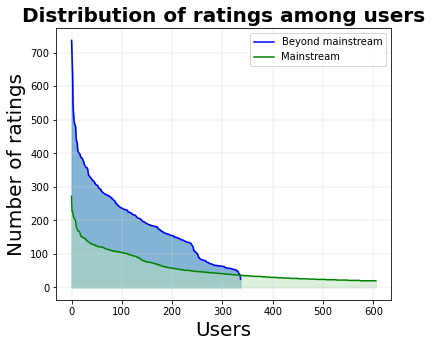

  Characteristic  Beyond-mainstream  Mainstream
0  Min. #Ratings          26.000000   21.000000
1  Max. #Ratings         738.000000  273.000000
2  Mean #Ratings         194.543027   58.386139
3        # Users         337.000000  606.000000


In [147]:
tau_cutoff = 0.07
compare_df = get_division_characteristics(user_mainstreamnesses, 'l20removed_tau007.png', tau_cutoff)

## Look into data characteristics when removing items < 50 ratings

Length of ranks_GIR_items: 604
Finished computing users' mainstreaminesses


<ipython-input-5-1d79585076c0>:8: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  grid.fit(d[:, None])


{'bandwidth': 0.1}


<ipython-input-134-8ea21f7a5a75>:8: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  kde.fit(taus_df[:, None])


(-0.001, 40.0)

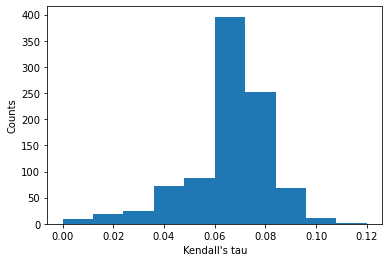

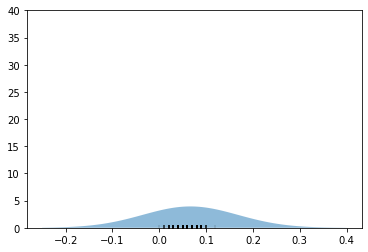

In [134]:
user_mainstreamnesses, taus_df = compute_taus(df, minimum=50)
best_bandwidth = compute_best_bandwidth(taus_df)

# instantiate and fit the KDE model
kde = KernelDensity(bandwidth=best_bandwidth['bandwidth'], kernel='gaussian')
x_d2 = np.linspace(-0.25, 0.4, 1000)

kde.fit(taus_df[:, None])

# score_samples returns the log of the probability density
logprob = kde.score_samples(x_d2[:, None])

plt.figure(1)
plt.fill_between(x_d2, np.exp(logprob), alpha=0.5)
plt.plot(taus_df, np.full_like(taus_df, -0.01), '|k', markeredgewidth=0.2)
plt.ylim(-0.001, 40)

### Divide users into two groups, based on mainstreaminess score, and compare group-size characteristics

259
684
Index(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10',
       ...
       '1673', '1674', '1675', '1676', '1677', '1678', '1679', '1680', '1681',
       '1682'],
      dtype='object', name='item', length=1682)
Index(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10',
       ...
       '1673', '1674', '1675', '1676', '1677', '1678', '1679', '1680', '1681',
       '1682'],
      dtype='object', name='item', length=1682)


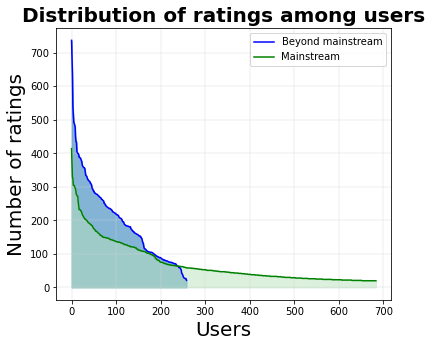

  Characteristic  Beyond-mainstream  Mainstream
0  Min. #Ratings          22.000000   21.000000
1  Max. #Ratings         738.000000  415.000000
2  Mean #Ratings         197.675676   72.726608
3        # Users         259.000000  684.000000


In [135]:
tau_cutoff = 0.06
compare_df = get_division_characteristics(user_mainstreamnesses, test_saving_file, tau_cutoff)

## Look into data characteristics when removing items < 100 ratings

Length of ranks_GIR_items: 339
Finished computing users' mainstreaminesses


<ipython-input-5-1d79585076c0>:8: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  grid.fit(d[:, None])


{'bandwidth': 0.1}


<ipython-input-136-4b13de2c5ab0>:8: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  kde.fit(taus_df[:, None])


(-0.001, 40.0)

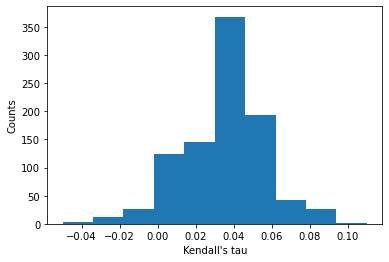

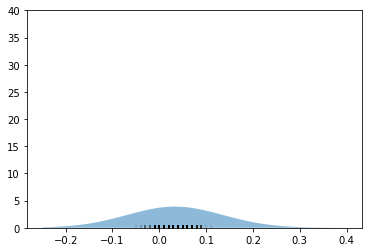

In [136]:
user_mainstreamnesses, taus_df = compute_taus(df, minimum=100)
best_bandwidth = compute_best_bandwidth(taus_df)

# instantiate and fit the KDE model
kde = KernelDensity(bandwidth=best_bandwidth['bandwidth'], kernel='gaussian')
x_d2 = np.linspace(-0.25, 0.4, 1000)

kde.fit(taus_df[:, None])

# score_samples returns the log of the probability density
logprob = kde.score_samples(x_d2[:, None])

plt.figure(1)
plt.fill_between(x_d2, np.exp(logprob), alpha=0.5)
plt.plot(taus_df, np.full_like(taus_df, -0.01), '|k', markeredgewidth=0.2)
plt.ylim(-0.001, 40)

### Divide users into two groups, based on mainstreaminess score, and compare group-size characteristics

898
45
Index(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10',
       ...
       '1673', '1674', '1675', '1676', '1677', '1678', '1679', '1680', '1681',
       '1682'],
      dtype='object', name='item', length=1682)
Index(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10',
       ...
       '1673', '1674', '1675', '1676', '1677', '1678', '1679', '1680', '1681',
       '1682'],
      dtype='object', name='item', length=1682)


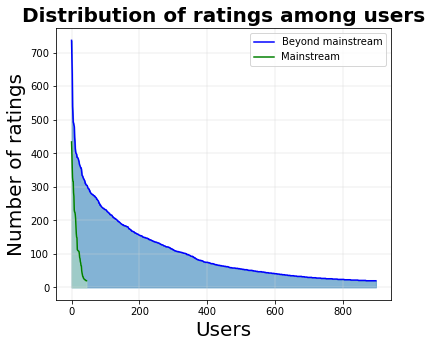

  Characteristic  Beyond-mainstream  Mainstream
0  Min. #Ratings          21.000000   21.000000
1  Max. #Ratings         738.000000  435.000000
2  Mean #Ratings         105.566815  136.533333
3        # Users         898.000000   45.000000


In [137]:
tau_cutoff = 0.07
compare_df = get_division_characteristics(user_mainstreamnesses, test_saving_file, tau_cutoff)

## Look into data characteristics when removing items < 20 & > 200 ratings

Length of ranks_GIR_items: 822
Finished computing users' mainstreaminesses


<ipython-input-5-1d79585076c0>:8: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  grid.fit(d[:, None])


{'bandwidth': 0.1}


<ipython-input-138-0b253c61dd5c>:8: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  kde.fit(taus_df[:, None])


(-0.001, 40.0)

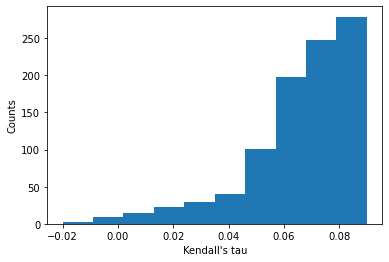

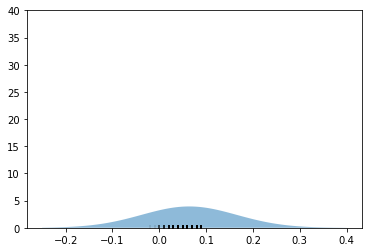

In [138]:
user_mainstreamnesses, taus_df = compute_taus(df, minimum=20, maximum=200)
best_bandwidth = compute_best_bandwidth(taus_df)

# instantiate and fit the KDE model
kde = KernelDensity(bandwidth=best_bandwidth['bandwidth'], kernel='gaussian')
x_d2 = np.linspace(-0.25, 0.4, 1000)

kde.fit(taus_df[:, None])

# score_samples returns the log of the probability density
logprob = kde.score_samples(x_d2[:, None])

plt.figure(1)
plt.fill_between(x_d2, np.exp(logprob), alpha=0.5)
plt.plot(taus_df, np.full_like(taus_df, -0.01), '|k', markeredgewidth=0.2)
plt.ylim(-0.001, 40)

### Divide users into two groups, based on mainstreaminess score, and compare group-size characteristics

303
640
Index(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10',
       ...
       '1673', '1674', '1675', '1676', '1677', '1678', '1679', '1680', '1681',
       '1682'],
      dtype='object', name='item', length=1682)
Index(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10',
       ...
       '1673', '1674', '1675', '1676', '1677', '1678', '1679', '1680', '1681',
       '1682'],
      dtype='object', name='item', length=1682)


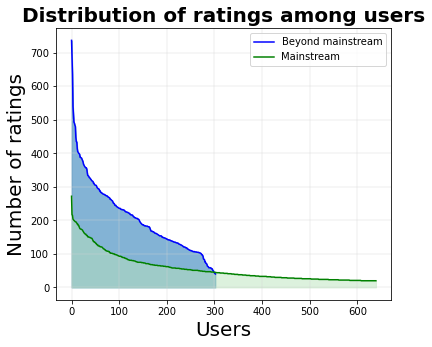

  Characteristic  Beyond-mainstream  Mainstream
0  Min. #Ratings          41.000000   21.000000
1  Max. #Ratings         738.000000  273.000000
2  Mean #Ratings         209.877888   58.359375
3        # Users         303.000000  640.000000


In [139]:
tau_cutoff = 0.06
compare_df = get_division_characteristics(user_mainstreamnesses, test_saving_file, tau_cutoff)

## Look into data characteristics when removing items > 100 ratings

Length of ranks_GIR_items: 1348
Finished computing users' mainstreaminesses


<ipython-input-5-1d79585076c0>:8: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  grid.fit(d[:, None])


{'bandwidth': 0.1}


<ipython-input-140-2254ba162342>:8: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  kde.fit(taus_df[:, None])


(-0.001, 40.0)

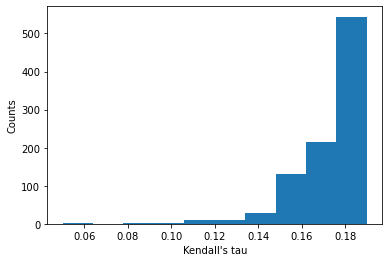

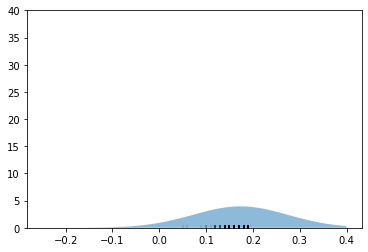

In [140]:
user_mainstreamnesses, taus_df = compute_taus(df, minimum=0, maximum=100)
best_bandwidth = compute_best_bandwidth(taus_df)

# instantiate and fit the KDE model
kde = KernelDensity(bandwidth=best_bandwidth['bandwidth'], kernel='gaussian')
x_d2 = np.linspace(-0.25, 0.4, 1000)

kde.fit(taus_df[:, None])

# score_samples returns the log of the probability density
logprob = kde.score_samples(x_d2[:, None])

plt.figure(1)
plt.fill_between(x_d2, np.exp(logprob), alpha=0.5)
plt.plot(taus_df, np.full_like(taus_df, -0.01), '|k', markeredgewidth=0.2)
plt.ylim(-0.001, 40)

### Divide users into two groups, based on mainstreaminess score, and compare group-size characteristics

646
297
Index(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10',
       ...
       '1673', '1674', '1675', '1676', '1677', '1678', '1679', '1680', '1681',
       '1682'],
      dtype='object', name='item', length=1682)
Index(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10',
       ...
       '1673', '1674', '1675', '1676', '1677', '1678', '1679', '1680', '1681',
       '1682'],
      dtype='object', name='item', length=1682)


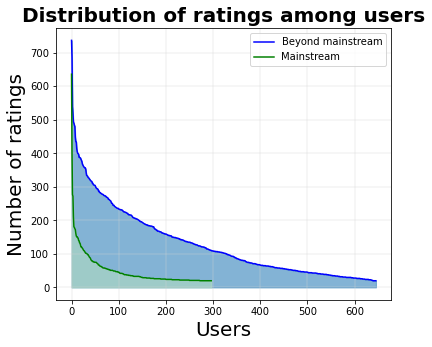

  Characteristic  Beyond-mainstream  Mainstream
0  Min. #Ratings          21.000000   21.000000
1  Max. #Ratings         738.000000  637.000000
2  Mean #Ratings         132.422601   51.845118
3        # Users         646.000000  297.000000


In [141]:
tau_cutoff = 0.18
compare_df = get_division_characteristics(user_mainstreamnesses, test_saving_file, tau_cutoff)

## Look into data characteristics when removing items > 200 ratings

Length of ranks_GIR_items: 1565
Finished computing users' mainstreaminesses


<ipython-input-5-1d79585076c0>:8: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  grid.fit(d[:, None])


{'bandwidth': 0.1}


<ipython-input-142-fbe1ccd2bcbb>:8: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  kde.fit(taus_df[:, None])


(-0.001, 40.0)

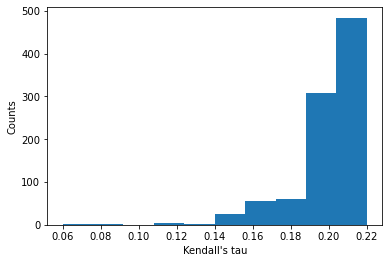

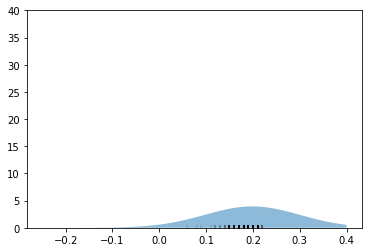

In [142]:
user_mainstreamnesses, taus_df = compute_taus(df, minimum=0, maximum=200)
best_bandwidth = compute_best_bandwidth(taus_df)

# instantiate and fit the KDE model
kde = KernelDensity(bandwidth=best_bandwidth['bandwidth'], kernel='gaussian')
x_d2 = np.linspace(-0.25, 0.4, 1000)

kde.fit(taus_df[:, None])

# score_samples returns the log of the probability density
logprob = kde.score_samples(x_d2[:, None])

plt.figure(1)
plt.fill_between(x_d2, np.exp(logprob), alpha=0.5)
plt.plot(taus_df, np.full_like(taus_df, -0.01), '|k', markeredgewidth=0.2)
plt.ylim(-0.001, 40)

### Divide users into two groups, based on mainstreaminess score, and compare group-size characteristics

25
918
Index(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10',
       ...
       '1673', '1674', '1675', '1676', '1677', '1678', '1679', '1680', '1681',
       '1682'],
      dtype='object', name='item', length=1682)
Index(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10',
       ...
       '1673', '1674', '1675', '1676', '1677', '1678', '1679', '1680', '1681',
       '1682'],
      dtype='object', name='item', length=1682)


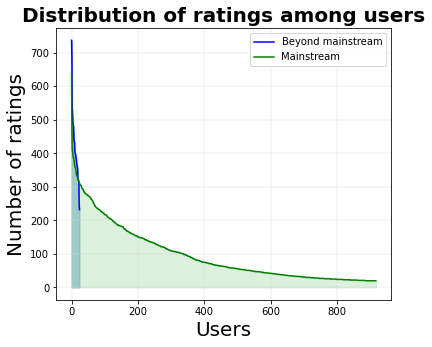

  Characteristic  Beyond-mainstream  Mainstream
0  Min. #Ratings              233.0   21.000000
1  Max. #Ratings              738.0  637.000000
2  Mean #Ratings              419.2   98.543573
3        # Users               25.0  918.000000


In [143]:
tau_cutoff = 0.15
compare_df = get_division_characteristics(user_mainstreamnesses, test_saving_file, tau_cutoff)